<a href="https://colab.research.google.com/github/mt-cs/statistics-of-ai/blob/main/AI_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Collaborative Filtering Recommendation System Using MovieLens Data

Data Exploration, Preprocessing, and Initial Model Development

Authors: Marisa Tania, Navya Sugandham

In [1]:
!pip install numpy==1.26.4


In [2]:
!pip install scikit-surprise


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split


# 1. Understanding Recommendation Systems

Recommendation systems aim to predict which **items** (e.g., movies) a **user** will like based on past behavior.

## Collaborative Filtering (this project)
Collaborative filtering uses **user–item interactions** (ratings) to make recommendations.

- **User-based CF:** recommend items liked by *similar users*.
- **Item-based CF:** recommend items similar to what the user already liked.

**Key assumption:** if users agreed in the past, they are likely to agree in the future.

## Content-Based Filtering (contrast)
Content-based filtering recommends items based on **item attributes** (genre, cast, keywords) and a user’s profile.
It does **not** require other users’ ratings, but it depends on having reliable item metadata.

In this notebook, we build a collaborative filtering baseline using **matrix factorization (SVD)**.

In [4]:
# Load MovieLens 100k dataset from Surprise
data = Dataset.load_builtin('ml-100k')

# Confirm dataset loaded
print("MovieLens 100k dataset loaded successfully")


Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
MovieLens 100k dataset loaded successfully


# 2. Data Exploration and Preprocessing

We inspect the dataset, check for missing values and duplicates, and visualize rating behavior
(e.g., rating distribution, ratings per user, ratings per movie). These steps help identify sparsity
and potential biases that can affect recommendation quality.

The dataset includes:
1. user_id: Unique identifier for users
2. item_id: Unique identifier for items (e.g., movies).
3. rating: Rating given by the user to the item (usually between 1 and 5).

In [5]:
raw_ratings = data.raw_ratings

df = pd.DataFrame(raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
df = df.drop(columns=['timestamp'])

df.head()


,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [6]:
df.shape


(100000, 3)

In [7]:
df.isnull().sum()


,0
user_id,0
item_id,0
rating,0


In [8]:
df.duplicated().sum()


0

In [9]:
df = df.drop_duplicates()
df = df.dropna()

df.shape


(100000, 3)

In [10]:
# Validate ratings
df = df[(df['rating'] >= 1) & (df['rating'] <= 5)]

In [11]:
# Check sparsity
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_ratings = len(df)

sparsity = 1 - (n_ratings / (n_users * n_items))

print(f"Users: {n_users}")
print(f"Items: {n_items}")
print(f"Ratings: {n_ratings}")
print(f"Sparsity: {sparsity:.4f}")

Users: 943
Items: 1682
Ratings: 100000
Sparsity: 0.9370


In [12]:
# Remove extremely inactive users/items
min_user_ratings = 3
min_item_ratings = 3

user_counts = df['user_id'].value_counts()
item_counts = df['item_id'].value_counts()

df = df[df['user_id'].isin(user_counts[user_counts >= min_user_ratings].index)]
df = df[df['item_id'].isin(item_counts[item_counts >= min_item_ratings].index)]
df.shape

(99723, 3)

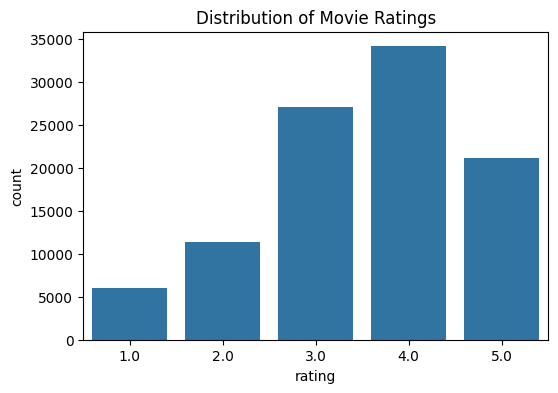

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title("Distribution of Movie Ratings")
plt.show()


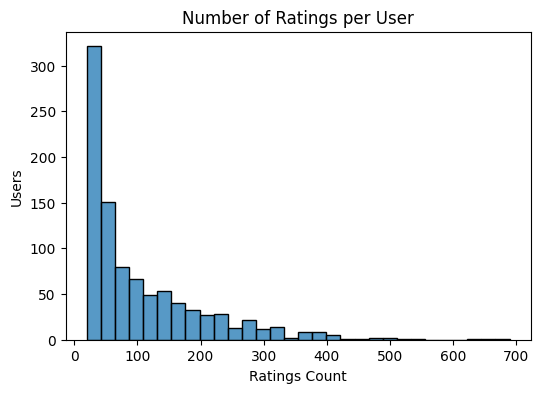

In [14]:
ratings_per_user = df.groupby('user_id')['rating'].count()

plt.figure(figsize=(6,4))
sns.histplot(ratings_per_user, bins=30)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Users")
plt.show()


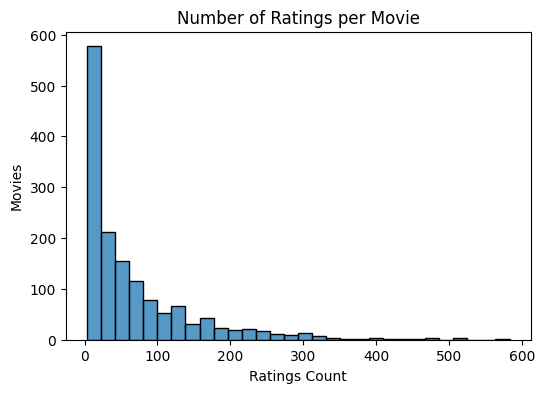

In [15]:
ratings_per_movie = df.groupby('item_id')['rating'].count()

plt.figure(figsize=(6,4))
sns.histplot(ratings_per_movie, bins=30)
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Movies")
plt.show()


In [16]:
# Define rating scale
reader = Reader(rating_scale=(1, 5))

# Load data into Surprise format
data_surprise = Dataset.load_from_df(
    df[['user_id', 'item_id', 'rating']],
    reader
)


# 3. Data Splitting

We split the dataset into **training** and **testing** sets. The model learns from the training set and is evaluated on the test set.

In [17]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data_surprise, test_size=0.25, random_state=42)

print("Train-test split completed")


Train-test split completed


# 4. Model Selection: SVD Collaborative Filtering

We start with **SVD (Singular Value Decomposition)**, a matrix factorization method that learns latent user and item factors.
This is a strong baseline for rating prediction tasks.


In [18]:
model = SVD()
model.fit(trainset)

print("SVD model trained successfully")


SVD model trained successfully


# 5. Model Evaluation (RMSE)

We evaluate rating prediction accuracy using **Root Mean Squared Error (RMSE)**.
Lower RMSE indicates predicted ratings are closer to true user ratings.

In [19]:
predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)


RMSE: 0.9358
RMSE: 0.935788084212762


# 6. Hyperparameter Tuning (Grid Search)

We tune SVD hyperparameters such as:
- `n_factors`: number of latent factors
- `n_epochs`: training iterations
- `lr_all`: learning rate
- `reg_all`: regularization strength

We use cross-validation (`cv=3`) and optimize for **RMSE**.

In [20]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 40],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search.fit(data_surprise)

print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best params:", grid_search.best_params['rmse'])

Best RMSE score: 0.9266043748042544
Best params: {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}


## 6b. Expanded Hyperparameter Tuning (RMSE + MAE)

Below is an expanded grid search that also tracks **MAE** (Mean Absolute Error).  

In [21]:
from surprise.model_selection import GridSearchCV

# Expanded search space (feel free to adjust)
param_grid_expanded = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 40, 60],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

grid_search2 = GridSearchCV(
    SVD,
    param_grid_expanded,
    measures=['rmse', 'mae'],
    cv=3,
    n_jobs=-1
)
grid_search2.fit(data_surprise)

print("Best RMSE (CV):", grid_search2.best_score['rmse'])
print("Best params (RMSE):", grid_search2.best_params['rmse'])
print("Best MAE (CV):", grid_search2.best_score['mae'])
print("Best params (MAE):", grid_search2.best_params['mae'])

Best RMSE (CV): 0.9197546575439922
Best params (RMSE): {'n_factors': 150, 'n_epochs': 60, 'lr_all': 0.01, 'reg_all': 0.1}
Best MAE (CV): 0.7269727510588351
Best params (MAE): {'n_factors': 150, 'n_epochs': 60, 'lr_all': 0.01, 'reg_all': 0.1}


# 7. Train Best Model and Generate Top-N Recommendations

After tuning, we retrain SVD using the best hyperparameters on the training set, evaluate RMSE on the test set,
then generate **Top-N** recommendations by predicting ratings for items the user has not rated (the *anti-testset*).

In [22]:
best_params = grid_search.best_params['rmse']
best_model = SVD(**best_params)
best_model.fit(trainset)

best_predictions = best_model.test(testset)
best_rmse = accuracy.rmse(best_predictions)
print("Test RMSE (best SVD):", best_rmse)

RMSE: 0.9185
Test RMSE (best SVD): 0.918461315473621


## 7a. Final Model Evaluation (RMSE + MAE)

After selecting the best hyperparameters with expanded grid search 2, we retrain on the full training set and evaluate on the held-out test set using **RMSE** and **MAE**.

In [23]:
best_params_final = grid_search2.best_params['rmse']

final_model = SVD(**best_params_final)
final_model.fit(trainset)

final_predictions = final_model.test(testset)

final_rmse = accuracy.rmse(final_predictions, verbose=True)
final_mae = accuracy.mae(final_predictions, verbose=True)

print("Best params:", best_params_final)
print("Final Test RMSE:", final_rmse)
print("Final Test MAE:", final_mae)

RMSE: 0.9071
MAE:  0.7173
Best params: {'n_factors': 150, 'n_epochs': 60, 'lr_all': 0.01, 'reg_all': 0.1}
Final Test RMSE: 0.9071133155689552
Final Test MAE: 0.7173406168275015


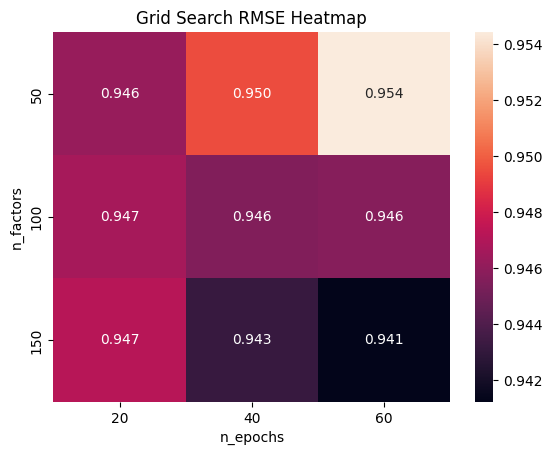

In [34]:
import seaborn as sns
import pandas as pd

results_df = pd.DataFrame(grid_search2.cv_results)

pivot = results_df.pivot_table(
    values="mean_test_rmse",
    index="param_n_factors",
    columns="param_n_epochs"
)

sns.heatmap(pivot, annot=True, fmt=".3f")
plt.title("Grid Search RMSE Heatmap")
plt.xlabel("n_epochs")
plt.ylabel("n_factors")
plt.show()

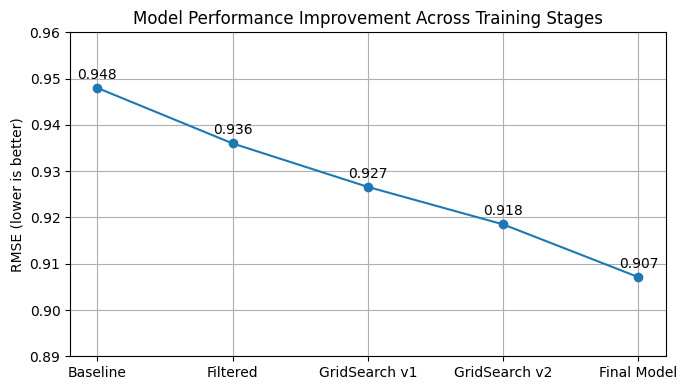

In [32]:
import matplotlib.pyplot as plt

stages = [
    "Baseline",
    "Filtered",
    "GridSearch v1",
    "GridSearch v2",
    "Final Model"
]

rmse_scores = [
    0.948,          # baseline
    0.936,          # filtered
    0.9266,         # first grid search CV
    0.9185,         # retrained tuned model
    0.9071          # final expanded grid
]

plt.figure(figsize=(7,4))

plt.plot(stages, rmse_scores, marker='o')

plt.ylabel("RMSE (lower is better)")
plt.title("Model Performance Improvement Across Training Stages")

for i, v in enumerate(rmse_scores):
    plt.text(i, v+0.002, f"{v:.3f}", ha='center')

plt.ylim(0.89, 0.96)
plt.grid(True)
plt.tight_layout()
plt.show()

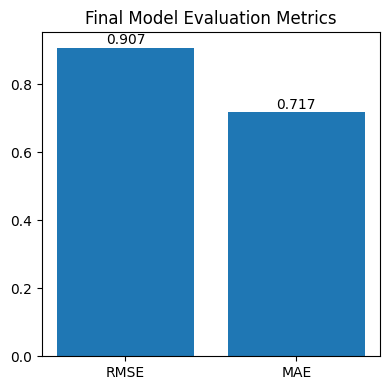

In [33]:
metrics = ["RMSE", "MAE"]
scores = [0.9071, 0.7173]

plt.figure(figsize=(4,4))
plt.bar(metrics, scores)

plt.title("Final Model Evaluation Metrics")

for i, v in enumerate(scores):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

## 7b. Residual Analysis

Residuals help see where the model under/over-predicts ratings.


               true          pred      residual
count  24931.000000  24931.000000  24931.000000
mean       3.545586      3.535184      0.010401
std        1.118150      0.600999      0.907072
min        1.000000      1.000000     -3.820044
25%        3.000000      3.164444     -0.545027
50%        4.000000      3.587954      0.086016
75%        4.000000      3.963495      0.644924
max        5.000000      5.000000      3.457794


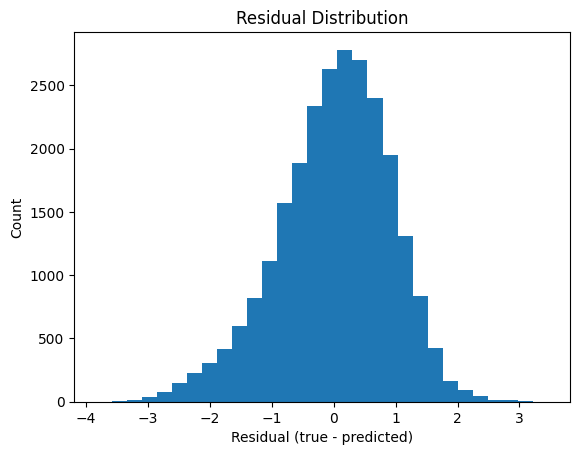

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

residuals_df = pd.DataFrame([
    {'uid': uid, 'iid': iid, 'true': true_r, 'pred': est, 'residual': true_r - est}
    for (uid, iid, true_r, est, _) in final_predictions
])

print(residuals_df[['true','pred','residual']].describe())

plt.figure()
plt.hist(residuals_df['residual'], bins=30)
plt.xlabel("Residual (true - predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()

## 7c. Compare Alternative Algorithms

To try improving RMSE further, compare other Surprise algorithms (**SVDpp**, **NMF**, **KNNBaseline**).


In [26]:
from surprise import SVDpp, NMF, KNNBaseline
from surprise.model_selection import cross_validate

algo_candidates = {
    "SVD (tuned)": SVD(**best_params_final),
    "SVDpp": SVDpp(),
    "NMF": NMF(),
    "KNNBaseline": KNNBaseline()
}

results = []
for name, algo in algo_candidates.items():
    cv_res = cross_validate(algo, data_surprise, measures=['RMSE','MAE'], cv=3, verbose=False)
    results.append({
        'model': name,
        'rmse_mean': cv_res['test_rmse'].mean(),
        'mae_mean': cv_res['test_mae'].mean()
    })

results_df = pd.DataFrame(results).sort_values('rmse_mean')
results_df

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,model,rmse_mean,mae_mean
0,SVD (tuned),0.917986,0.725767
1,SVDpp,0.926396,0.727961
3,KNNBaseline,0.935596,0.737728
2,NMF,0.971358,0.763334


# 8. Generate Top-N Recommendations

After retrain, we generate **Top-N** recommendations by predicting ratings for items the user has not rated (the *anti-testset*).

In [25]:
def get_top_n(predictions, n=10):
    top_n = {}

    for uid, iid, true_r, est, _ in predictions:
        top_n.setdefault(uid, []).append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Build anti-testset: all user-item pairs NOT in the training data
anti_testset = trainset.build_anti_testset()
anti_predictions = final_model.test(anti_testset)

top_n = get_top_n(anti_predictions, n=10)

# Show Top-10 recommendations for a few users
for uid in list(top_n.keys())[:5]:
    print(f"User {uid} top-10 recommendations (item_id, predicted_rating):")
    print(top_n[uid])
    print("-" * 60)


User 272 top-10 recommendations (item_id, predicted_rating):
[('1449', 4.896365518409162), ('187', 4.832147027921652), ('64', 4.811928802667758), ('156', 4.7286816268933), ('603', 4.678916478665685), ('135', 4.6662370963437185), ('23', 4.665178710288849), ('182', 4.6633693041061886), ('641', 4.655375438078009), ('1169', 4.647027221627328)]
------------------------------------------------------------
User 890 top-10 recommendations (item_id, predicted_rating):
[('178', 4.956906244762989), ('285', 4.816542925997039), ('483', 4.710427540492419), ('1449', 4.709092550768837), ('357', 4.70692397037527), ('318', 4.6924154756629965), ('408', 4.6750289883897755), ('48', 4.631815351726992), ('488', 4.604001482513729), ('197', 4.5971921198594945)]
------------------------------------------------------------
User 295 top-10 recommendations (item_id, predicted_rating):
[('1449', 5), ('963', 4.9765823589312905), ('483', 4.9707906205676275), ('64', 4.933448204019614), ('170', 4.898544058113631), ('11

In [28]:
print(top_n[uid])

[('1449', 4.5391965790379825), ('408', 4.382214917438314), ('127', 4.369001303938692), ('302', 4.349278637534027), ('134', 4.279528856101794), ('611', 4.272538679777807), ('480', 4.2644885862230435), ('89', 4.248705713316873), ('657', 4.238309650146083), ('114', 4.2277583834095225)]


In [29]:
!wget -q https://files.grouplens.org/datasets/movielens/ml-100k/u.item

In [30]:
# Build a mapping item_id -> movie_title (MovieLens 100k: u.item)
movies = pd.read_csv("u.item", sep="|", encoding="latin-1", header=None,
                     usecols=[0,1], names=["item_id","title"])
id_to_title = dict(zip(movies["item_id"].astype(str), movies["title"]))

for uid in list(top_n.keys())[:5]:
    print(f"User {uid} top-10 recommendations:")
    for iid, est in top_n[uid]:
        print(f"  {id_to_title.get(iid, iid)}  (item_id={iid}, predicted={est:.2f})")
    print("-" * 60)

User 272 top-10 recommendations:
  Pather Panchali (1955)  (item_id=1449, predicted=4.90)
  Godfather: Part II, The (1974)  (item_id=187, predicted=4.83)
  Shawshank Redemption, The (1994)  (item_id=64, predicted=4.81)
  Reservoir Dogs (1992)  (item_id=156, predicted=4.73)
  Rear Window (1954)  (item_id=603, predicted=4.68)
  2001: A Space Odyssey (1968)  (item_id=135, predicted=4.67)
  Taxi Driver (1976)  (item_id=23, predicted=4.67)
  GoodFellas (1990)  (item_id=182, predicted=4.66)
  Paths of Glory (1957)  (item_id=641, predicted=4.66)
  Fresh (1994)  (item_id=1169, predicted=4.65)
------------------------------------------------------------
User 890 top-10 recommendations:
  12 Angry Men (1957)  (item_id=178, predicted=4.96)
  Secrets & Lies (1996)  (item_id=285, predicted=4.82)
  Casablanca (1942)  (item_id=483, predicted=4.71)
  Pather Panchali (1955)  (item_id=1449, predicted=4.71)
  One Flew Over the Cuckoo's Nest (1975)  (item_id=357, predicted=4.71)
  Schindler's List (1993) 

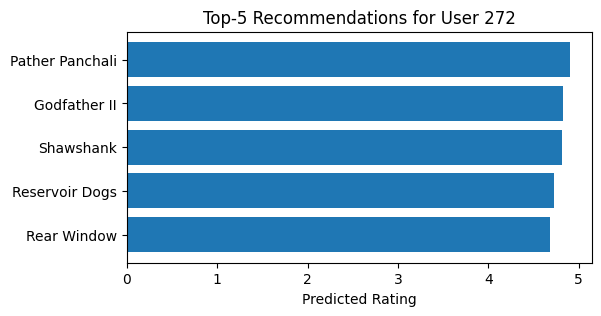

In [35]:
import matplotlib.pyplot as plt

movies = [
    "Pather Panchali", "Godfather II", "Shawshank",
    "Reservoir Dogs", "Rear Window"
]

scores = [4.90, 4.83, 4.81, 4.73, 4.68]

plt.figure(figsize=(6,3))
plt.barh(movies, scores)
plt.xlabel("Predicted Rating")
plt.title("Top-5 Recommendations for User 272")
plt.gca().invert_yaxis()
plt.show()


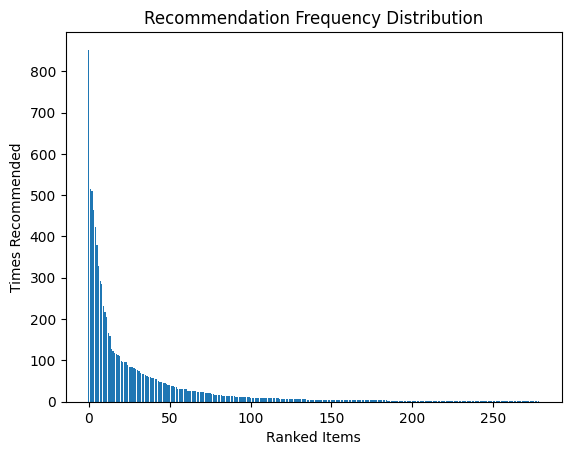

In [36]:
from collections import Counter

all_items = [iid for uid in top_n for iid, _ in top_n[uid]]
counts = Counter(all_items)

plt.bar(range(len(counts)), sorted(counts.values(), reverse=True))
plt.title("Recommendation Frequency Distribution")
plt.ylabel("Times Recommended")
plt.xlabel("Ranked Items")
plt.show()

To qualitatively assess recommendation quality, we generated Top-10 personalized movie recommendations for several users. The recommended items included highly rated and critically acclaimed films, indicating that the model successfully learned meaningful latent preference patterns from sparse user–item interactions.

1. Model is ranking plausibly high-quality movies, not random noise.
We see lots of:
*   The Godfather
*   Shawshank Redemption
*   Casablanca
*   12 Angry Men
*   Citizen Kane
*   Rear Window

2. Predictions are within rating scale
All estimates ≈ 4.2–5.0
This is expected because Top-N selects only the highest predicted ratings.

3. Personalized per user
Since lists differ per user, we confirm that user factors ≠ global popularity only and collaborative filtering is actually personalized

# 9. Ethical Considerations

Recommendation systems can create meaningful real-world impacts. While collaborative filtering improves personalization and user engagement, it also introduces several ethical and societal concerns that must be considered during development and deployment.

- **Bias & popularity effects:** Models can over-recommend popular items and under-represent niche content (*long-tail suppression*).
- **Filter bubbles:** Personalization may reduce exposure to diverse viewpoints or content.
- **Privacy:** User behavior data can be sensitive; minimize collection, restrict access, and avoid re-identification risks.
- **Transparency:** Users should understand that recommendations are algorithmic and based on prior interactions.
- **Fairness:** If demographic attributes exist, evaluate whether certain groups receive systematically lower-quality recommendations.

Inspection of the Top-N recommendations in our results showed that many users were repeatedly recommended widely popular and critically acclaimed movies (e.g., *The Shawshank Redemption*, *The Godfather*, *Casablanca*). While this indicates that the model successfully captures strong global preferences, it also suggests the presence of **popularity bias**, where frequently rated items dominate recommendations. This may limit exposure to niche or less-known content and reduce recommendation diversity.

To mitigate these risks, future improvements could incorporate diversity-aware or fairness-aware ranking strategies. For example, re-ranking techniques can balance predicted relevance with diversity to avoid repeatedly recommending the same popular items. Sampling or regularization approaches can also reduce overfitting to heavy users or popular movies. In addition, evaluating metrics such as recommendation coverage, diversity, and novelty alongside RMSE would provide a more holistic assessment of system performance.

Although the MovieLens dataset does not contain demographic or personally identifiable information, real-world deployments would require stronger safeguards, including anonymization, aggregation, restricted data access, and limited data retention policies to protect user privacy.

Overall, ethical considerations highlight that recommendation quality should not be measured solely by predictive accuracy. Responsible systems must balance accuracy with fairness, diversity, transparency, and user trust.
